In [124]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML


def summary(start_date, end_date):

    query = """
    with pre as (
    SELECT    
            smto.city_id
            ,smto.city_name
            ,smto.customer_account_id
            ,count(distinct smto.order_id) orders
            ,SUM(gfv_eur) AS gfv_eur
            ,SUM(dps_delivery_fee_eur) delivery_fee_eur
            ,sum(gmv_eur) gmv_eur
    FROM
        `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto 
    WHERE 
        smto.country_code = 'se'
        AND smto.created_date_local BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
        and has_new_customer_condition is true
        group by 1,2,3
    """

    return query


def data(start_date, end_date):

    query = """
    SELECT   smto.city_id
        ,smto.city_name
        ,extract(ISOWEEK from smto.created_date_local) week
        ,created_date_local date
        ,count(distinct smto.customer_account_id) total_users
        ,count(distinct smto.order_id) total_orders
        ,COUNT(DISTINCT smto.order_id) / NULLIF(COUNT(DISTINCT smto.customer_account_id), 0) AS order_per_user
        ,SUM(gfv_eur) AS gfv_eur
        ,SUM(gfv_eur) / NULLIF(COUNT(DISTINCT smto.customer_account_id), 0) AS gfv_eur_per_user
        ,SUM(dps_delivery_fee_eur) / NULLIF(COUNT(DISTINCT smto.order_id), 0) AS delivery_fee_per_order
        ,sum(gmv_eur) gmv_eur
    FROM 
        `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto 
    WHERE 
        smto.country_code = 'se'
        AND smto.created_date_local BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
        and has_new_customer_condition is true
        group by 1,2,3,4
    """

    return query


# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

start_date = '2024-04-17'
end_date = '2024-09-26'

# entity_id = 'DJ_CZ','FO_NO','MJM_AT','NP_HU','OP_SE','PO_FI','YS_TR','EF_GR','FY_CY','FP_BD','FP_HK','FP_KH','FP_LA','FP_MM','FP_MY','FP_PH','FP_PK','FP_SG','FP_TH','FP_TW','HS_SA','AP_PA','PY_AR','PY_BO','PY_CL','PY_CR','PY_DO','PY_EC','PY_GT','PY_HN','PY_NI','PY_PE','PY_PY','PY_SV','PY_UY','PY_VE','HF_EG','TB_AE',
# 'TB_BH','TB_IQ','TB_JO','TB_KW','TB_OM','TB_QA'

# entity_id = 'MJM_AT','PO_FI'
# entity_id_str = ",".join([f"'{entity}'" for entity in entity_id])

match_details_df = client.query(data(start_date, end_date)).to_dataframe()

#a = client.query(summary(start_date, end_date)).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 



BadRequest: 400 Syntax error: Expected ")" but got end of script at [17:23]; reason: invalidQuery, location: query, message: Syntax error: Expected ")" but got end of script at [17:23]

Location: US
Job ID: 15b0f105-f3fe-4ff3-8455-cb869d0a2d25


In [ ]:
a

,city_id,city_name,customer_account_id,orders,gfv_eur,delivery_fee_eur,gmv_eur
0,260,Mjölby,opa4a5re,1,22.920000000,3.422000000,27.480000000
1,209,Jonkoping,op1mt1i5,1,28.110000000,0E-9,20.560000000
2,274,Kinna,opmaoftl,1,38.210000000,0E-9,39.340000000
3,221,Trollhattan,opt4c8cf,1,22.980000000,0E-9,27.190000000
4,263,Boden,opevs5xw,1,11.560000000,3.396000000,16.290000000
...,...,...,...,...,...,...,...
13736,202,Helsingborg,opg6q8yx,1,18.490000000,4.235000000,23.850000000
13737,202,Helsingborg,opt2zofi,1,63.550000000,0E-9,58.710000000
13738,202,Helsingborg,opv0n8ud,1,14.610000000,0E-9,15.210000000
13739,202,Helsingborg,opetk9wu,1,70.730000000,0E-9,79.420000000


In [ ]:
intervention_date = pd.to_datetime('2024-08-06')
match_details_df['period'] = np.where(match_details_df['date'] < intervention_date, 'Pre', 'Post')
filtered_df = match_details_df[match_details_df['city_name'].isin(['Uppsala','Vasteras' ,'Helsinborg','Orebro'])]
filtered_df

# intervention = {'Uppsala':'2024-08-06', 'Vasteras','Helsinborg','Orebro'}

,city_id,city_name,week,date,total_users,total_orders,order_per_user,gfv_eur,gfv_eur_per_user,delivery_fee_per_order,gmv_eur,period
5,12,Vasteras,33,2024-08-13,20,20,1.000000,423.010000000,21.150500000,0.425800000,356.880000000,Post
7,12,Vasteras,34,2024-08-25,32,33,1.031250,947.570000000,29.611562500,0.390272727,879.510000000,Post
28,203,Orebro,33,2024-08-16,17,17,1.000000,593.910000000,34.935882353,1.000941176,603.140000000,Post
34,12,Vasteras,31,2024-07-29,12,12,1.000000,402.290000000,33.524166667,2.366666667,433.960000000,Pre
35,12,Vasteras,32,2024-08-10,27,28,1.037037,754.110000000,27.930000000,0.577785714,742.580000000,Post
...,...,...,...,...,...,...,...,...,...,...,...,...
1374,4,Uppsala,34,2024-08-22,29,29,1.000000,737.080000000,25.416551724,0.445344828,643.770000000,Post
1375,4,Uppsala,29,2024-07-17,10,10,1.000000,240.300000000,24.030000000,3.137000000,266.010000000,Pre
1392,203,Orebro,34,2024-08-25,15,15,1.000000,365.670000000,24.378000000,0.572400000,353.110000000,Post
1394,12,Vasteras,29,2024-07-16,11,11,1.000000,335.980000000,30.543636364,1.851181818,366.210000000,Pre


In [ ]:
customers that we got

In [ ]:
customers got me to 

customers got me 

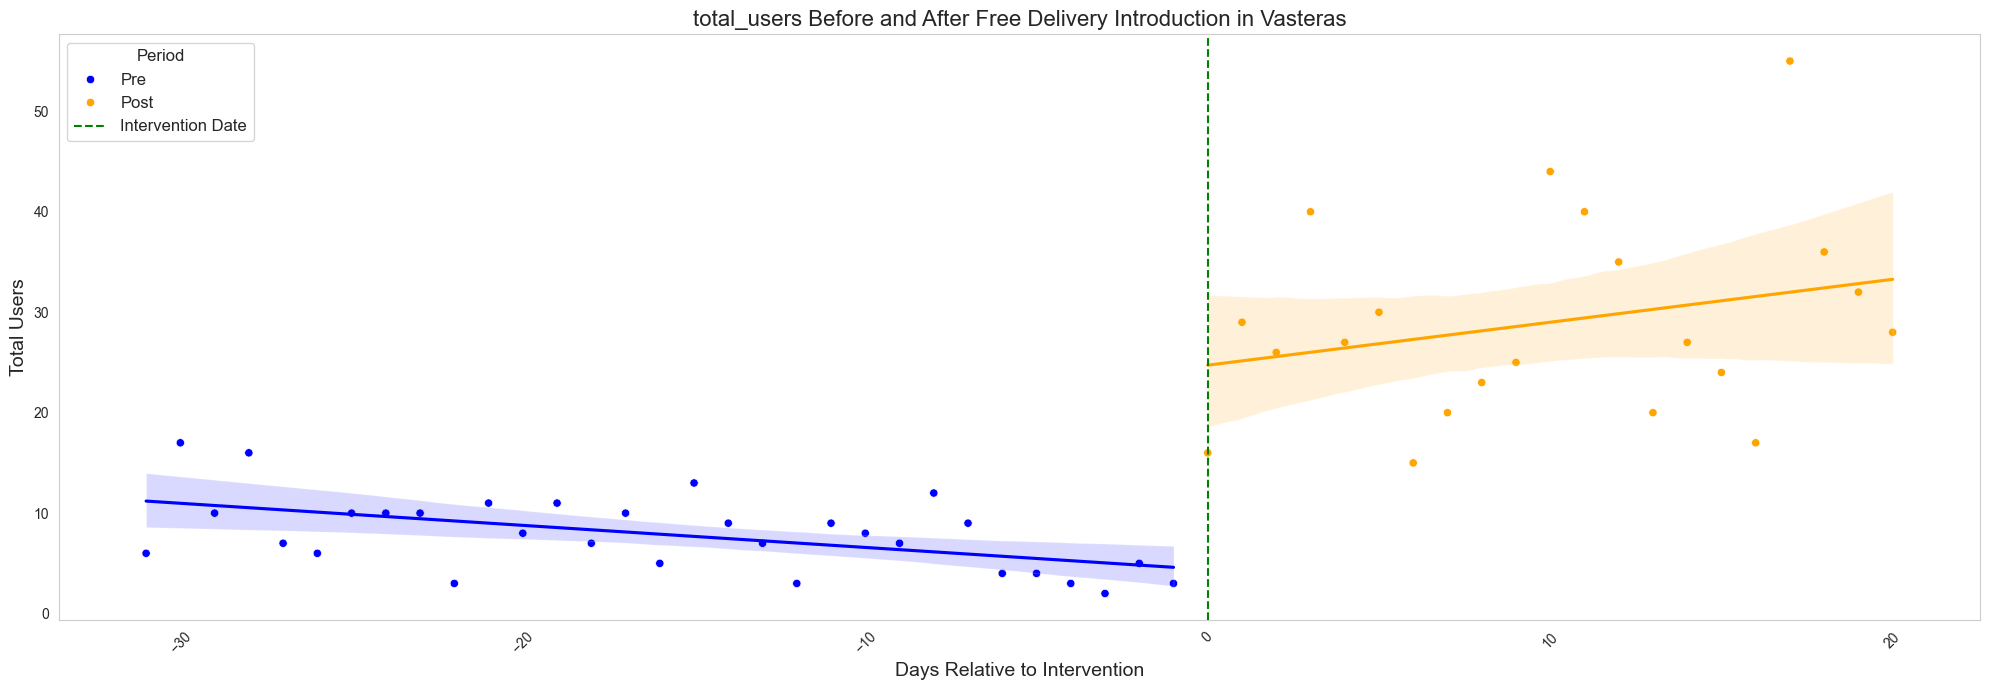

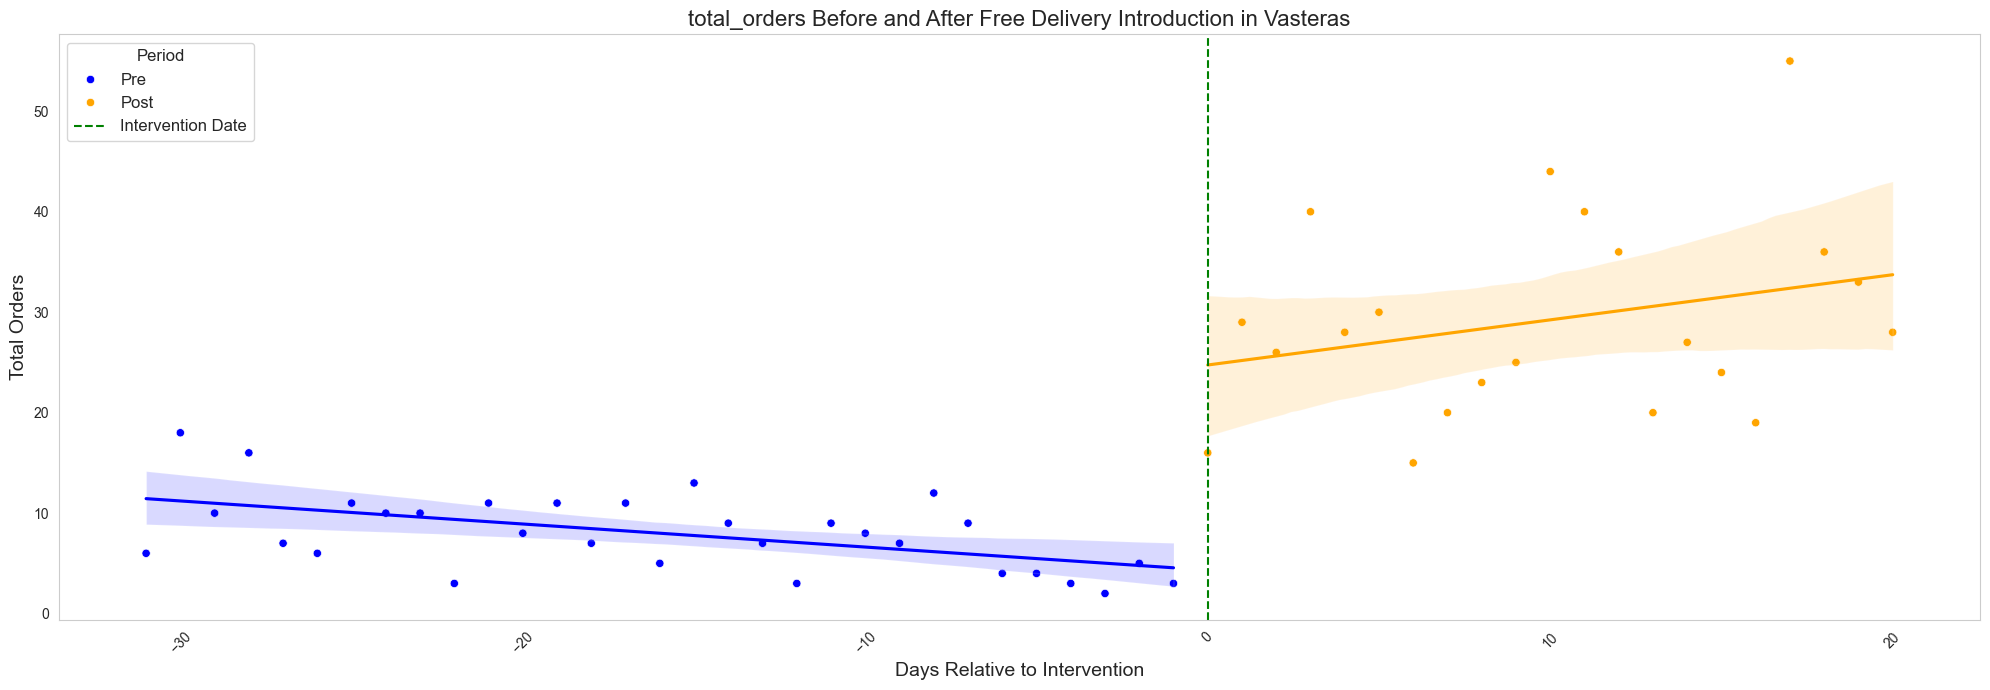

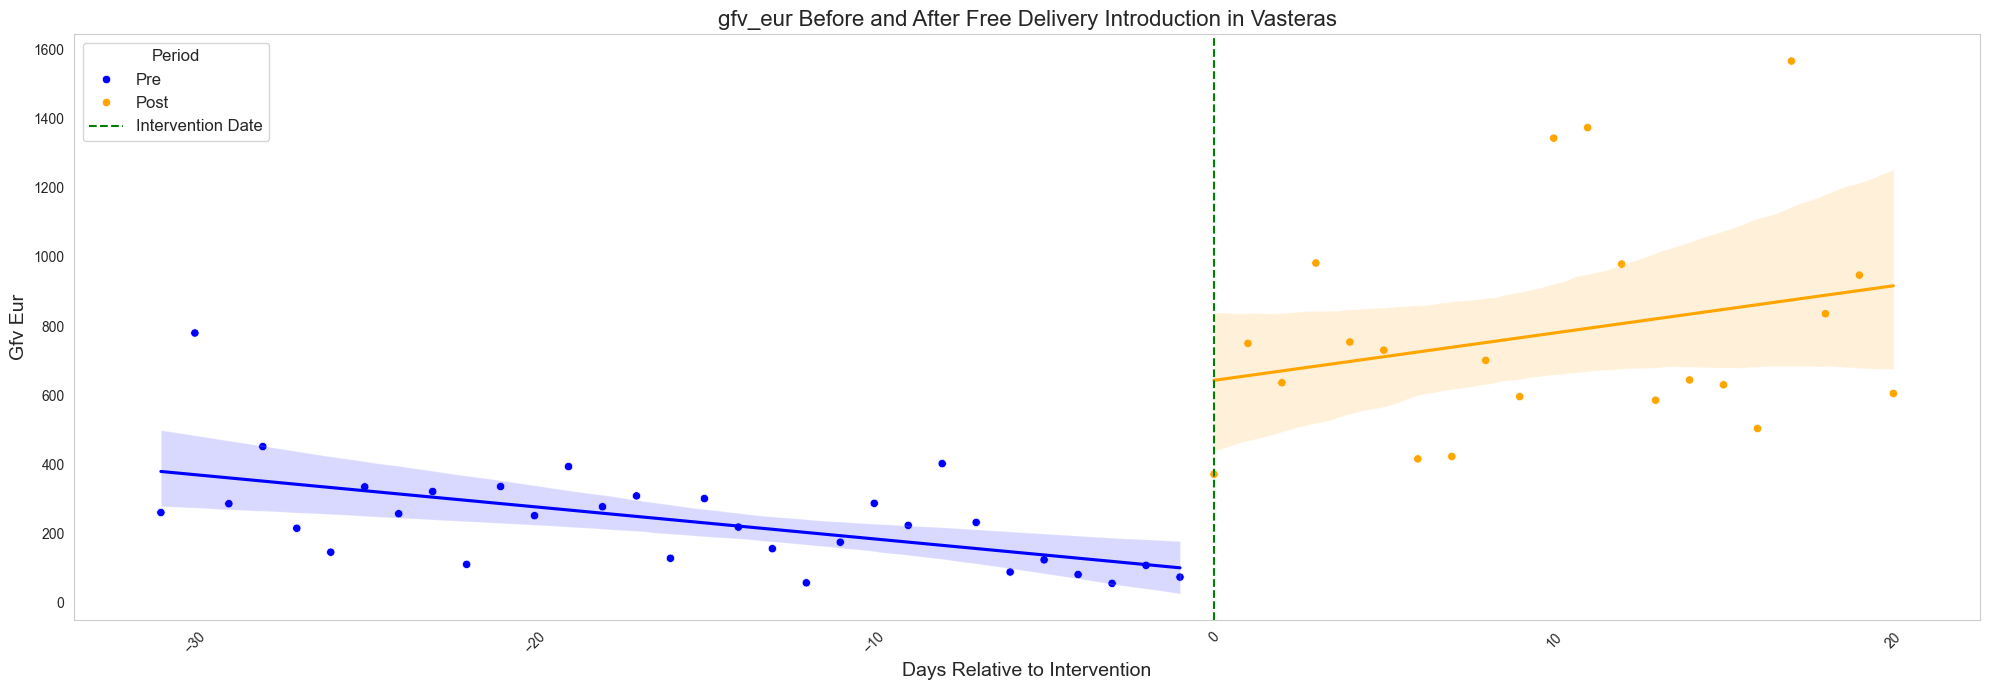

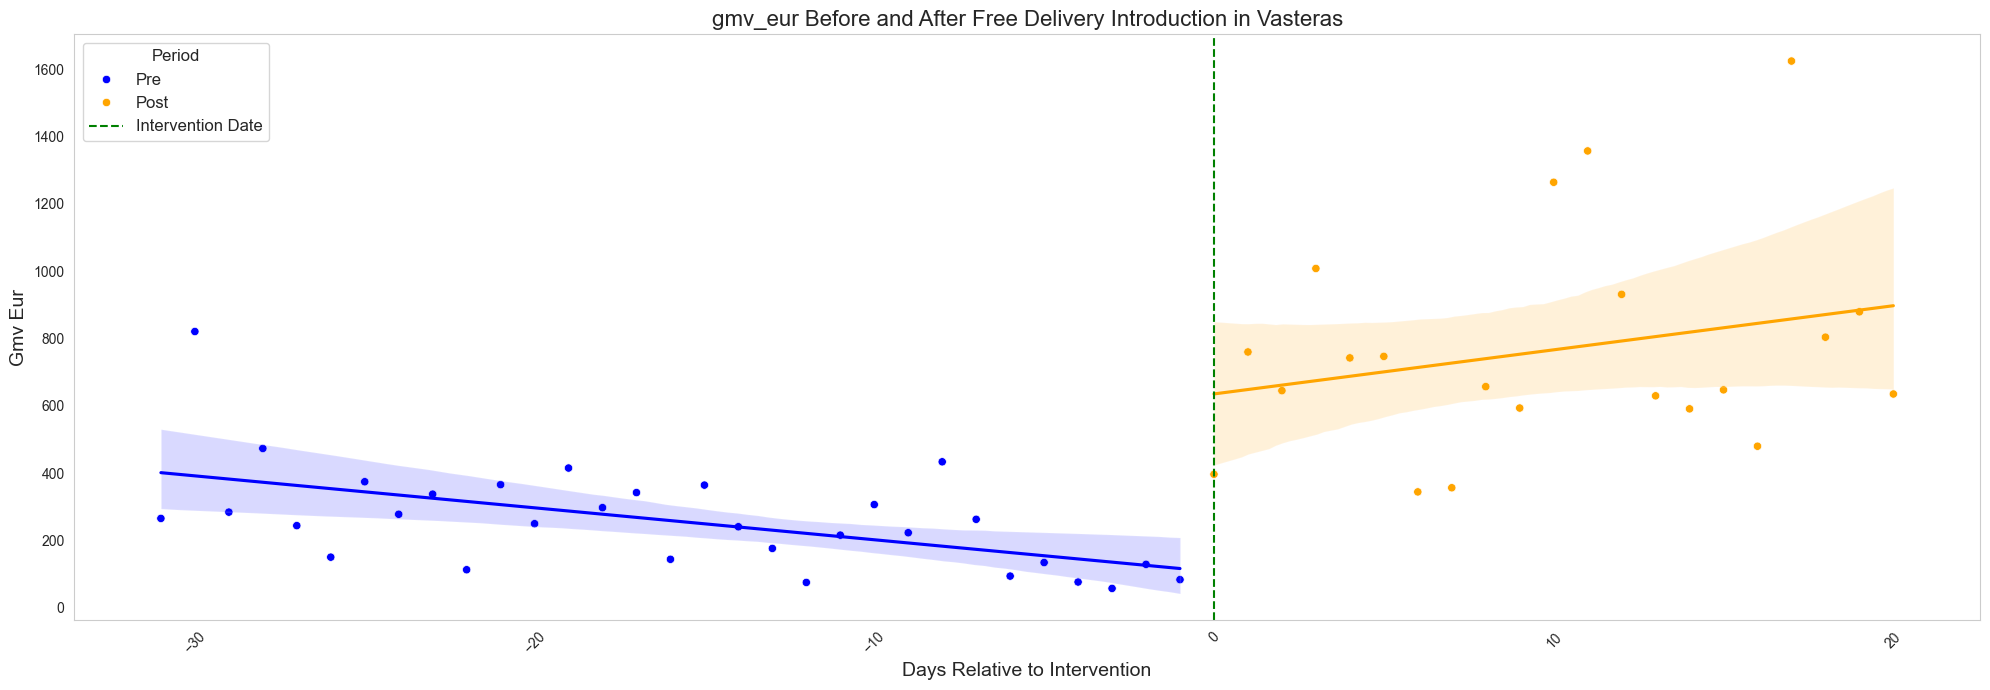

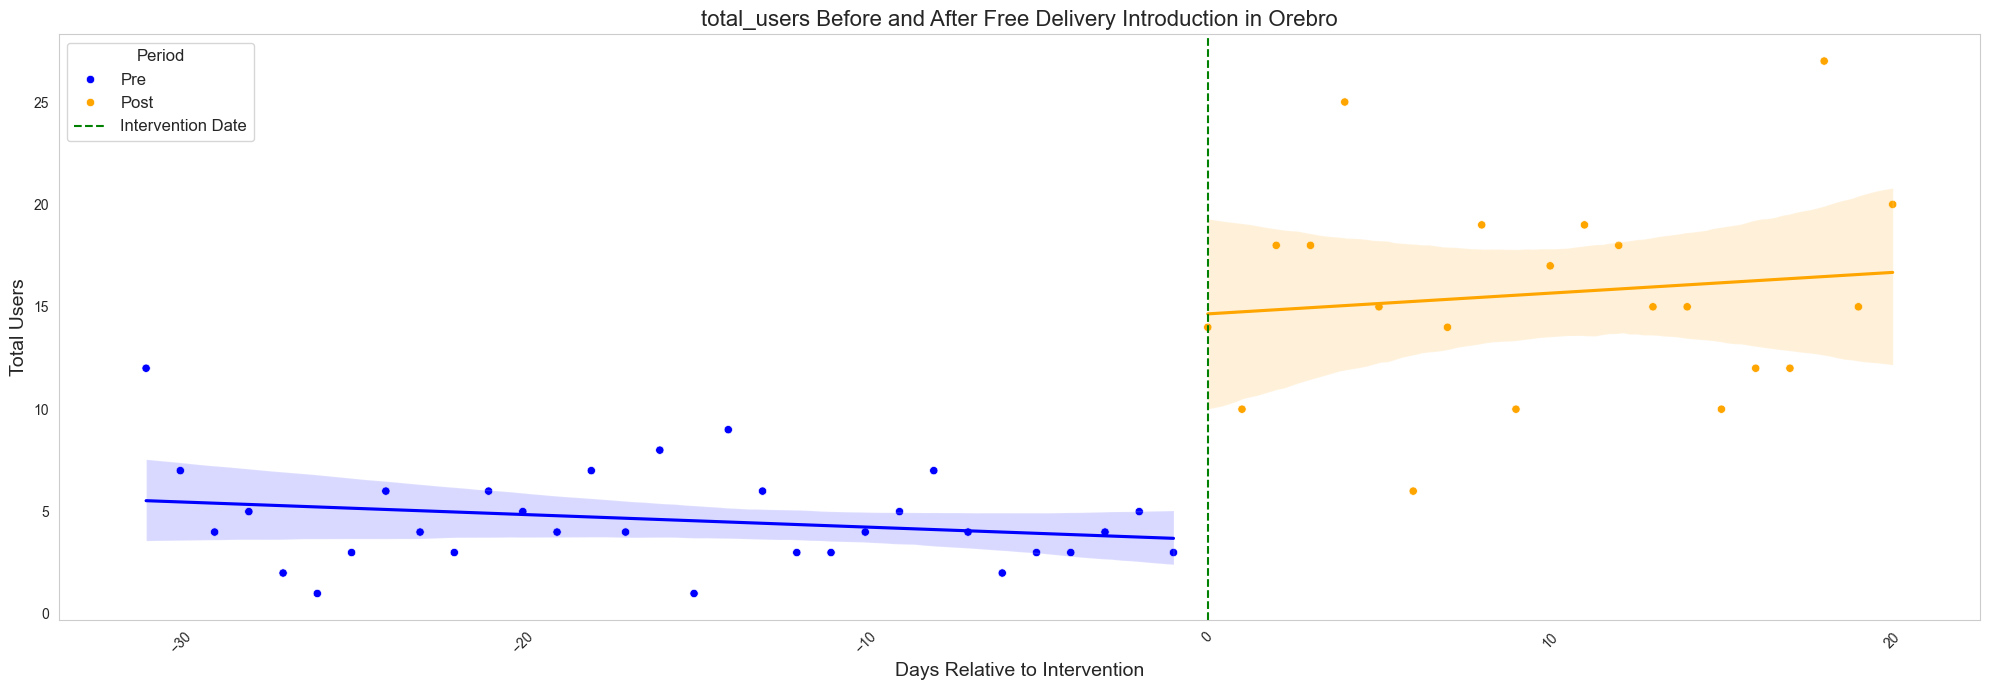

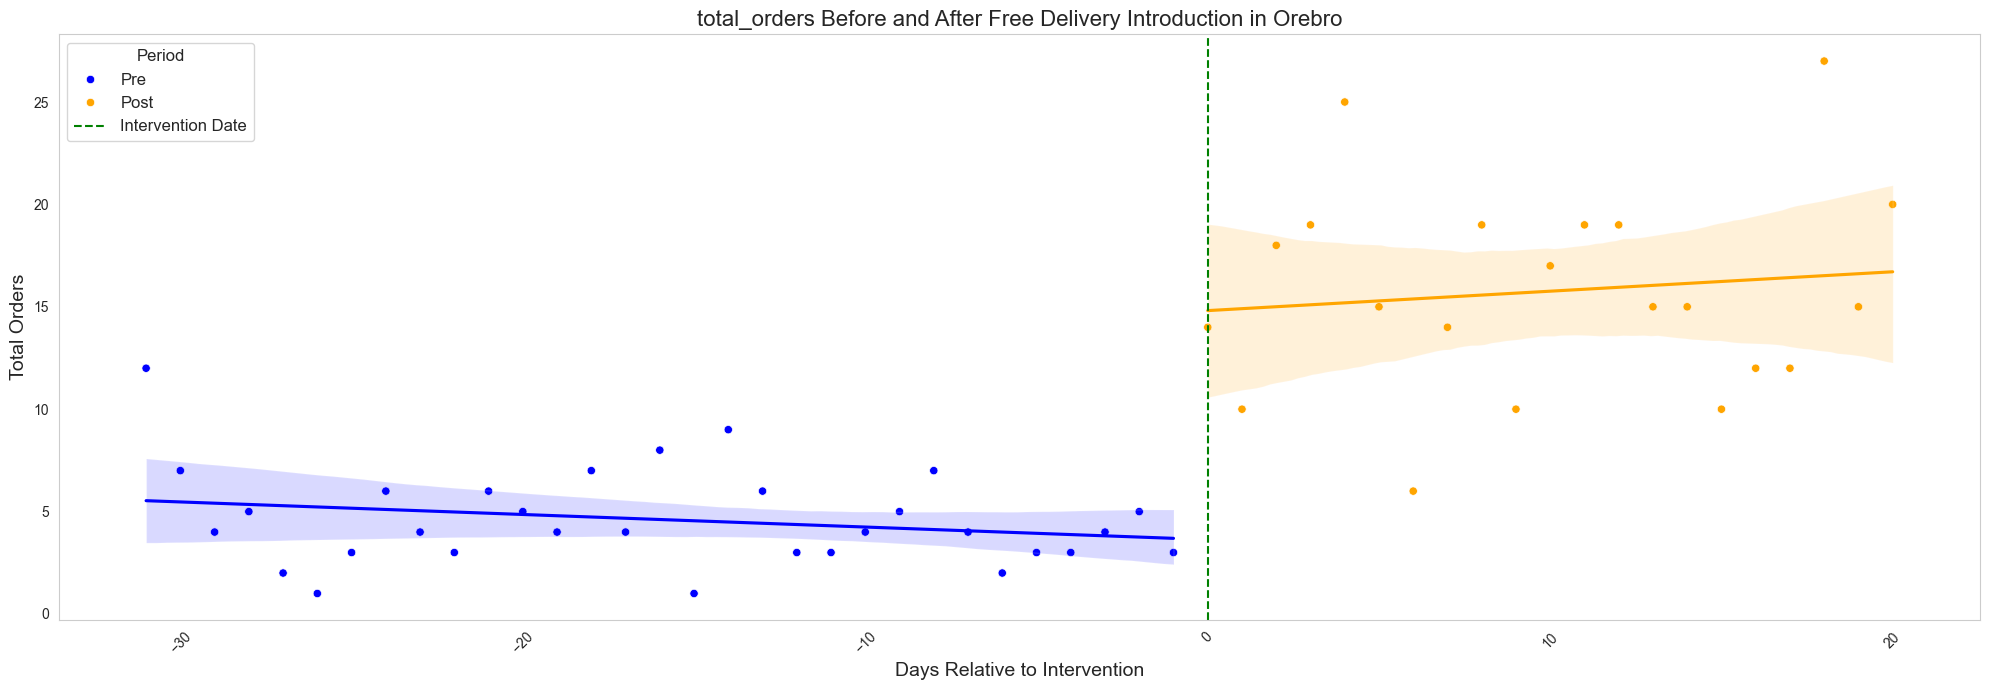

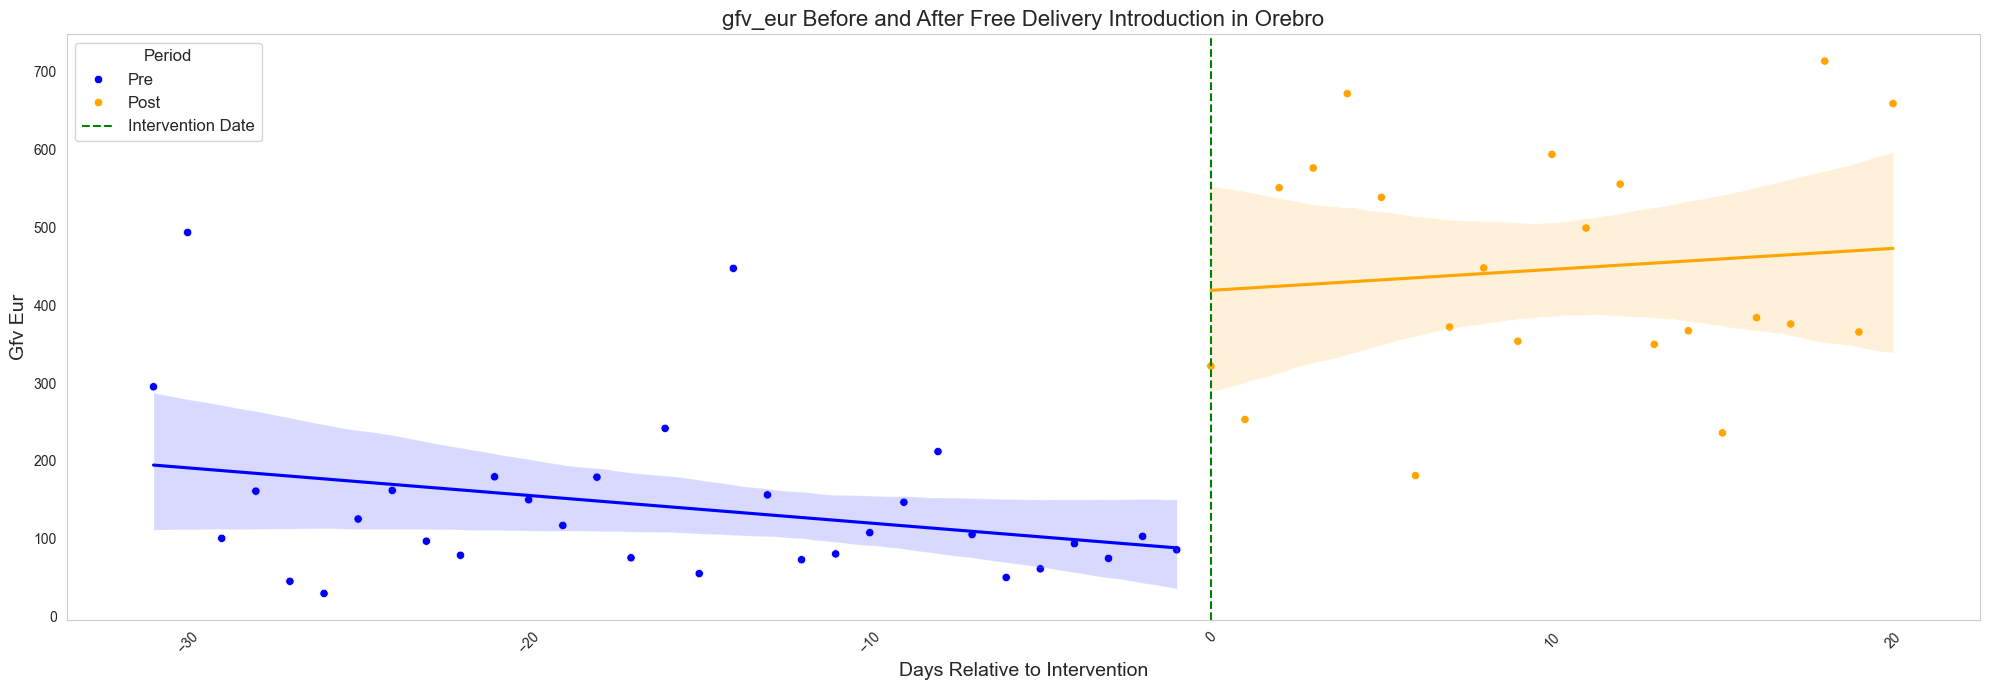

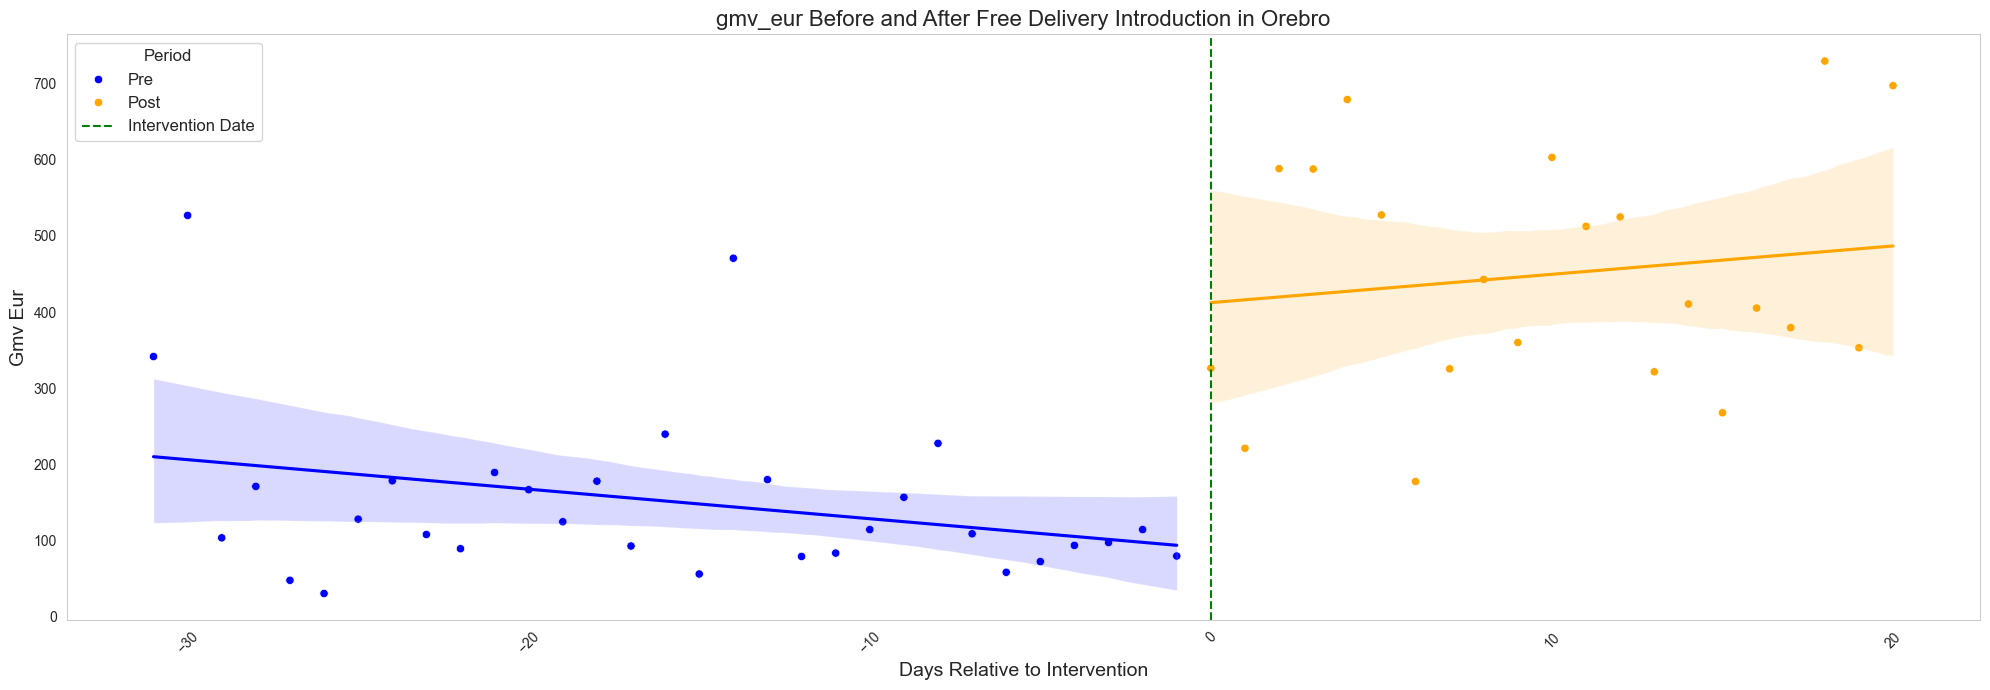

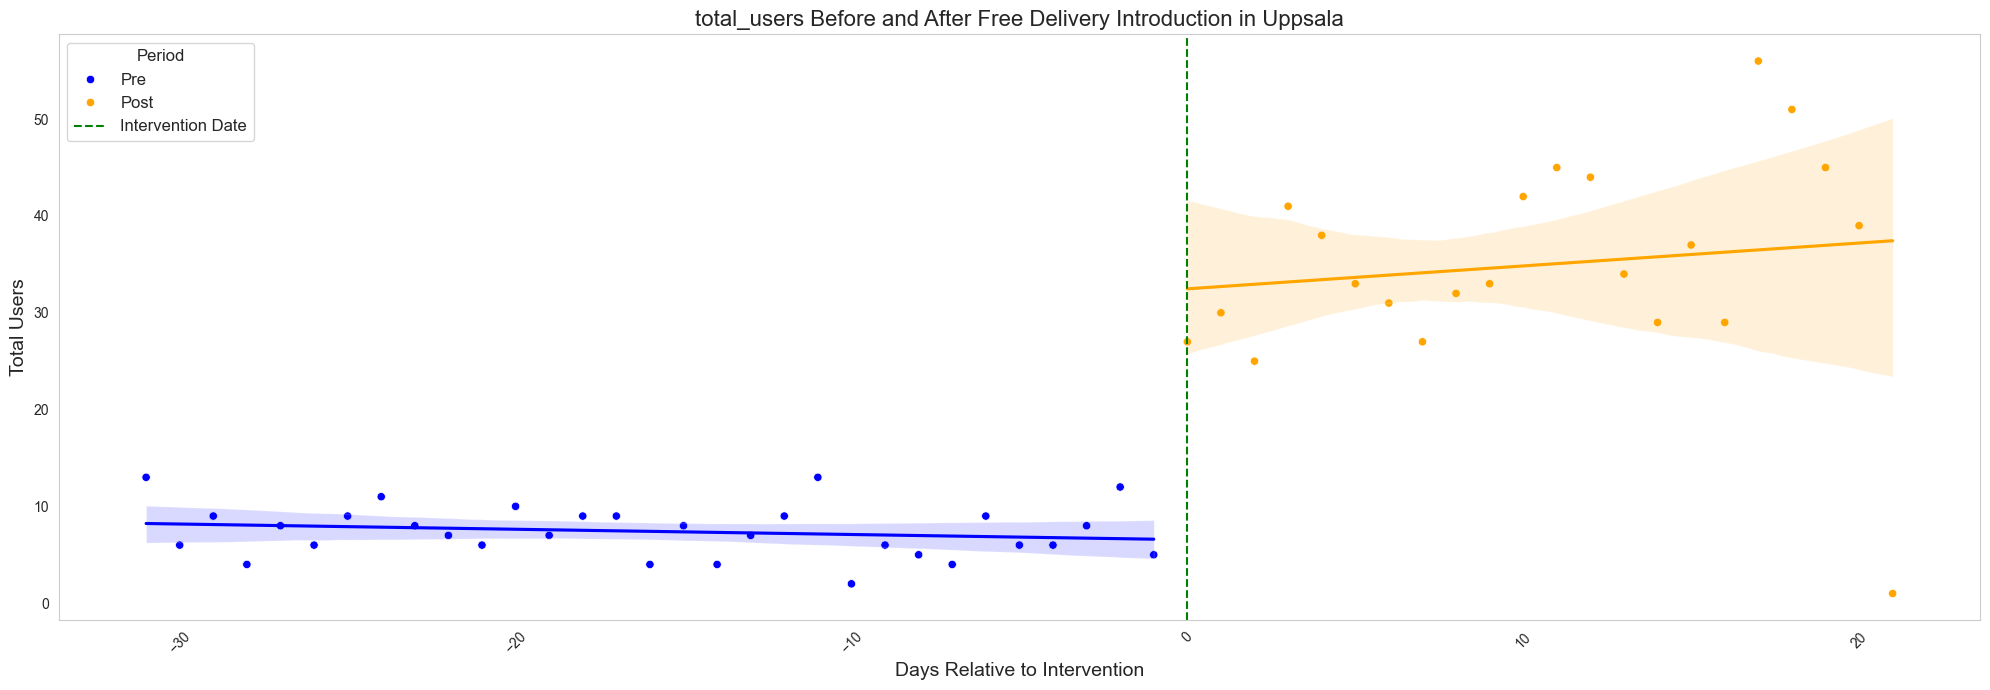

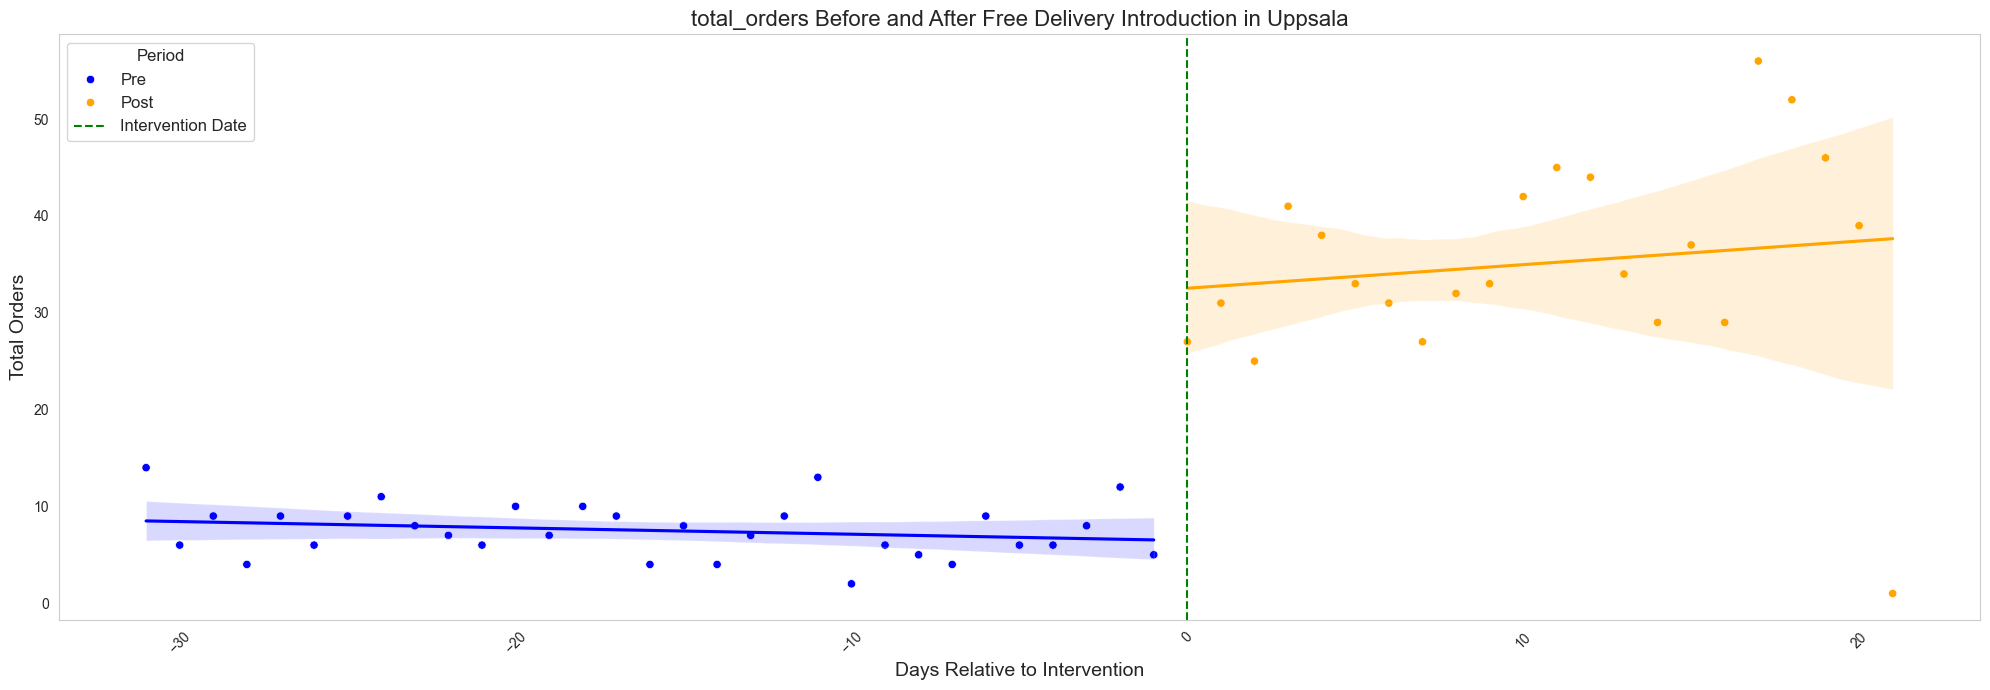

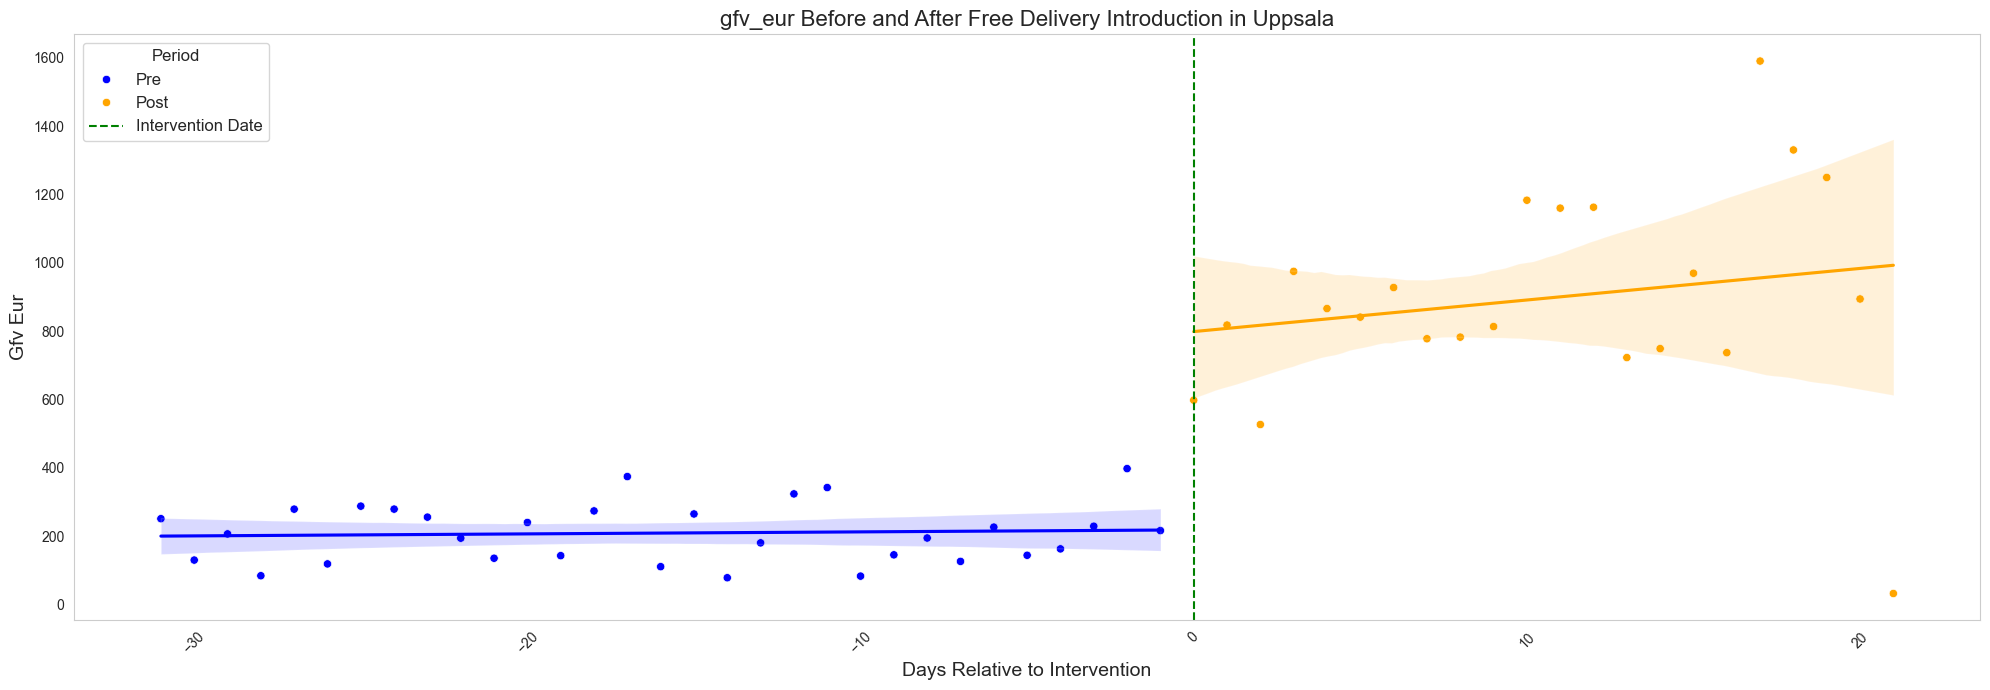

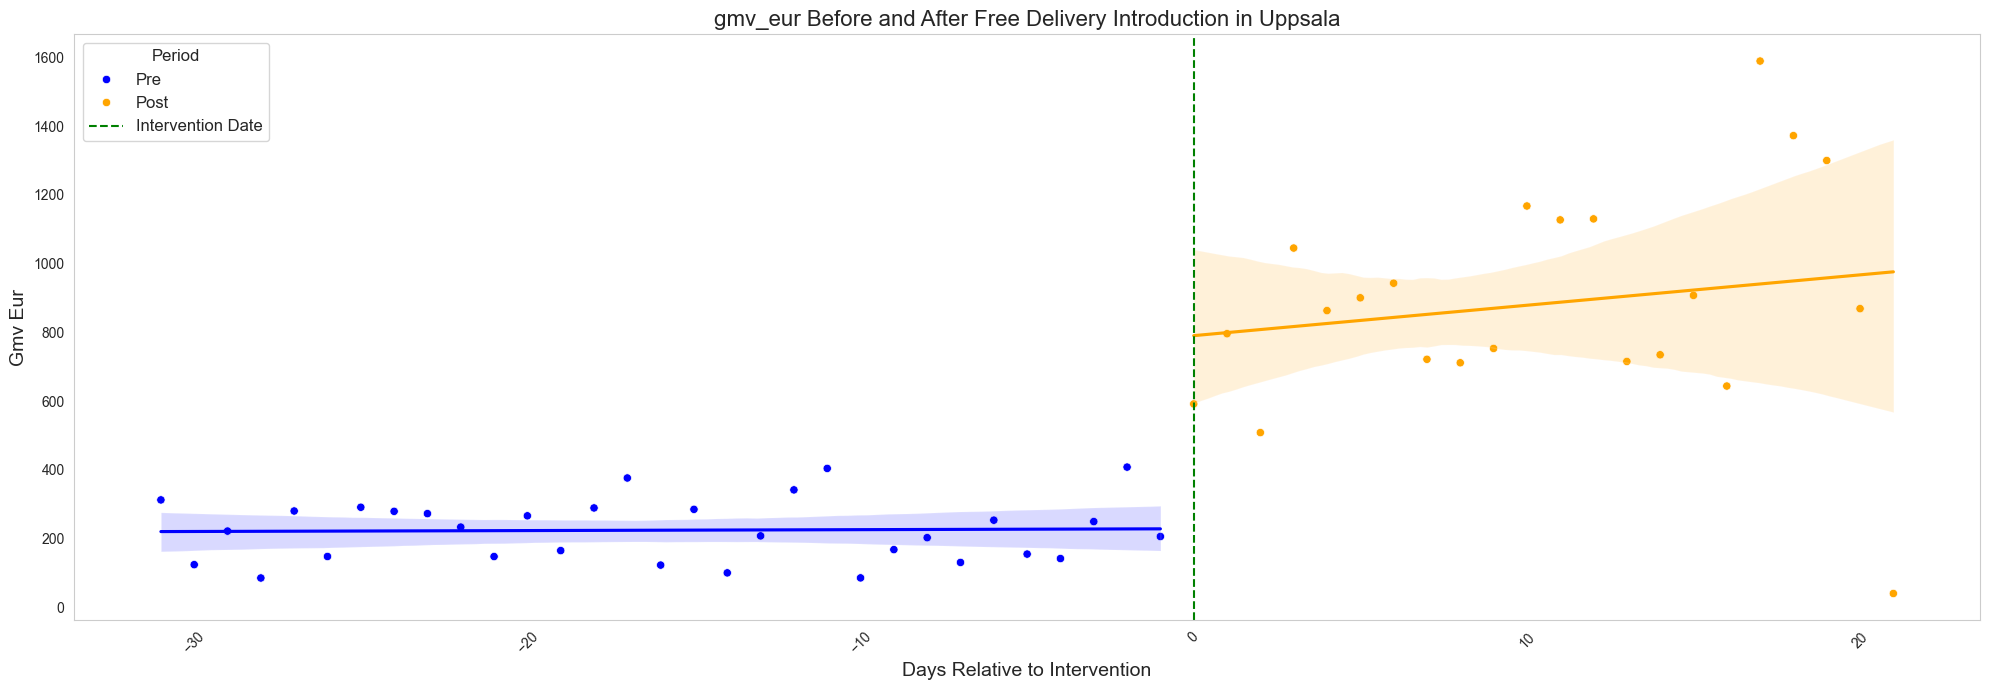

In [ ]:
# Define the metrics to be plotted
metric = ['total_users','total_orders','gfv_eur','gmv_eur']

# Define the intervention date
intervention_date = pd.to_datetime('2024-08-06')

# Loop over each city
for city in filtered_df['city_name'].unique():
    
    # Filter the data for the specific city
    data = filtered_df[(filtered_df['city_name'] == city)].copy()

    # Ensure that the 'date' column is in datetime format
    data['date'] = pd.to_datetime(data['date'])

    # Calculate the number of days relative to the intervention date
    data['days_from_intervention'] = (data['date'] - intervention_date).dt.days

    # Convert all metrics to float to avoid TypeError
    for m in metric:
        data[m] = data[m].astype(float)

        # Ensure data is sorted by the new 'days_from_intervention' column
        data = data.sort_values('days_from_intervention').reset_index(drop=True)

        # Set plot style
        sns.set_style('whitegrid')

        # Create a figure and axis
        plt.figure(figsize=(20, 7))

        # Plot the scatter plot using days_from_intervention as the x-axis
        sns.scatterplot(data=data, x='days_from_intervention', y=m, hue='period', palette=['blue', 'orange'])

        # Fit and plot a regression line for the pre-intervention period
        pre_intervention_data = data[data['days_from_intervention'] < 0]
        sns.regplot(data=pre_intervention_data, x='days_from_intervention', y=m, scatter=False, color='blue', line_kws={'label': 'Pre-Intervention Fit'})

        # Fit and plot a regression line for the post-intervention period
        post_intervention_data = data[data['days_from_intervention'] >= 0]
        sns.regplot(data=post_intervention_data, x='days_from_intervention', y=m, scatter=False, color='orange', line_kws={'label': 'Post-Intervention Fit'})

        # Add a vertical line at day 0 (the intervention date)
        plt.axvline(x=0, color='green', linestyle='--', label='Intervention Date')

        # Set titles and labels
        plt.title(f"{m} Before and After Free Delivery Introduction in {city}", fontsize=16)
        plt.xlabel('Days Relative to Intervention', fontsize=14)
        plt.ylabel(m.replace('_', ' ').title(), fontsize=14)

        # Customize legend
        plt.legend(title='Period', fontsize=12, title_fontsize=12)

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)

        # Remove gridlines
        plt.grid(False)
        
        # Show plot
        plt.tight_layout()
        plt.show()


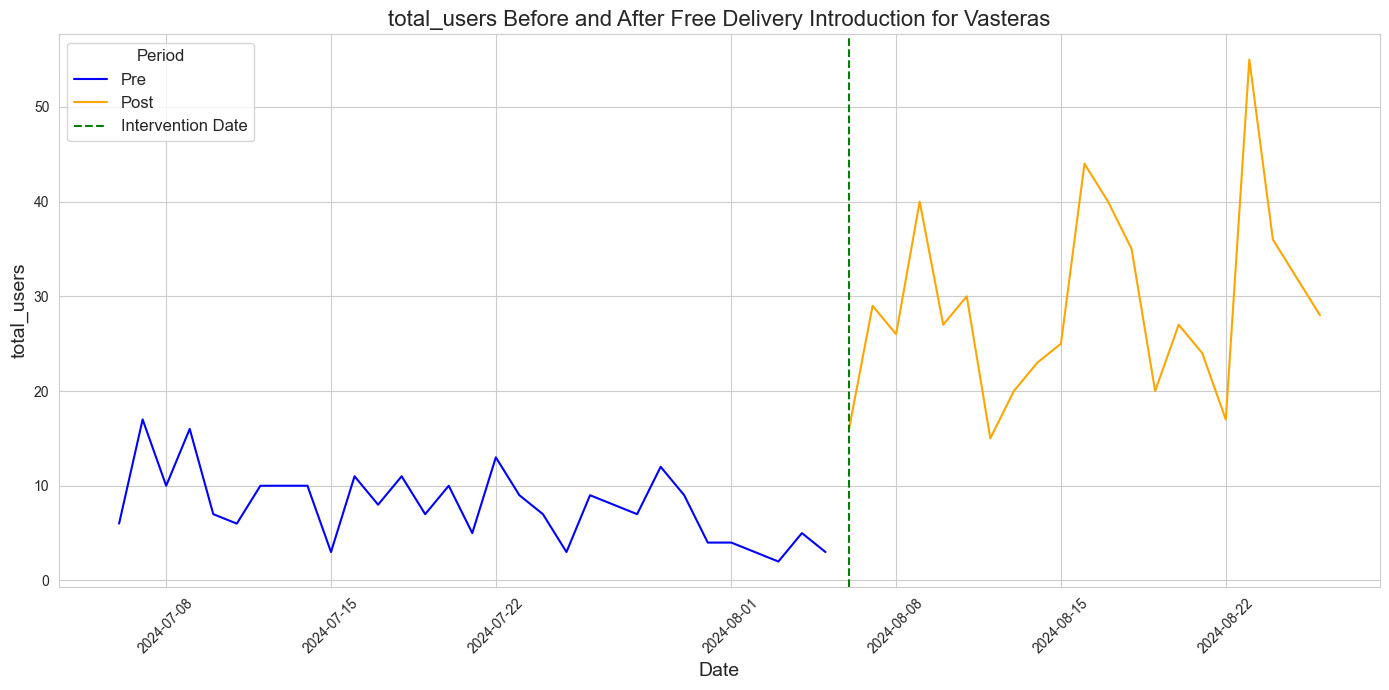

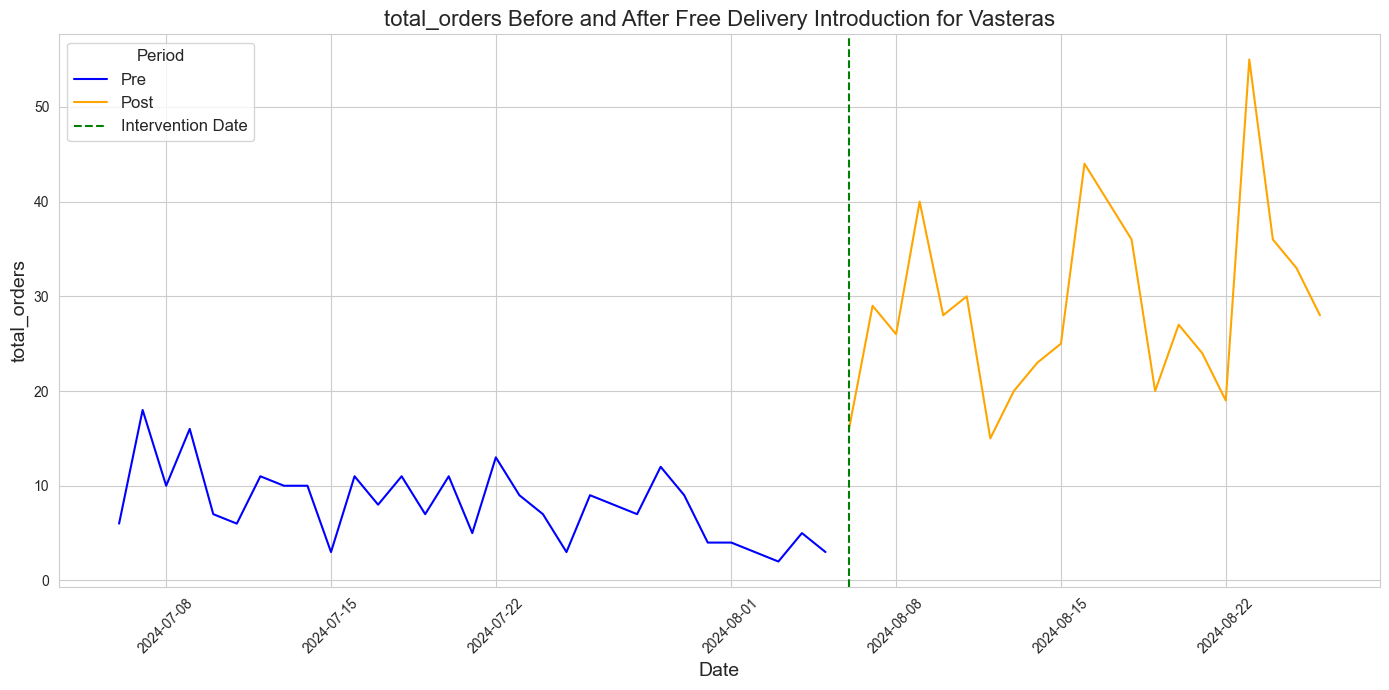

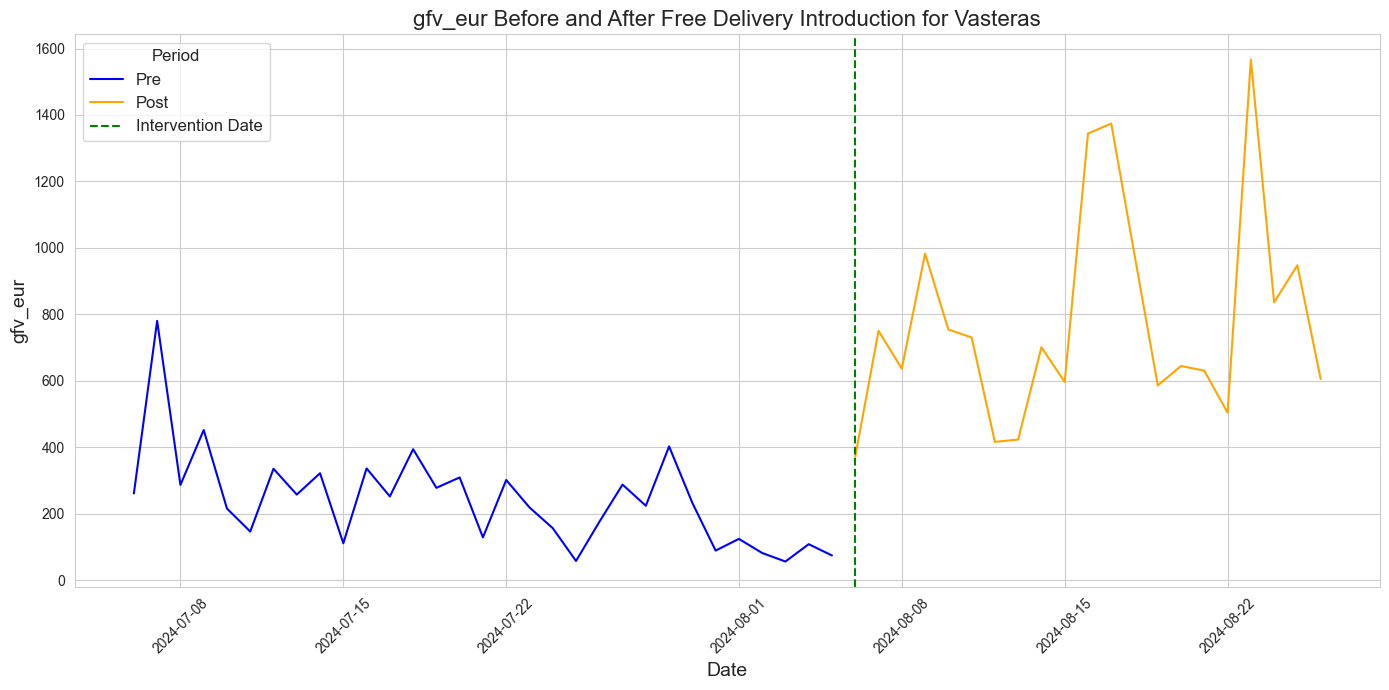

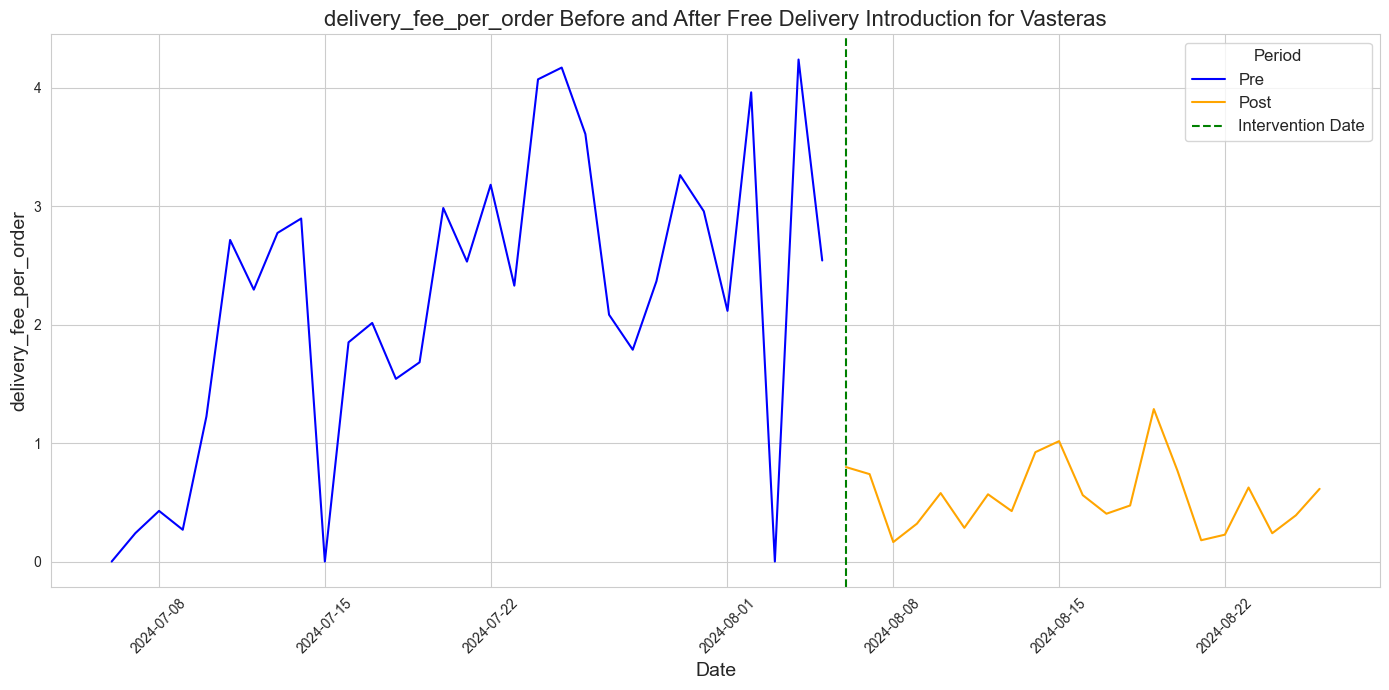

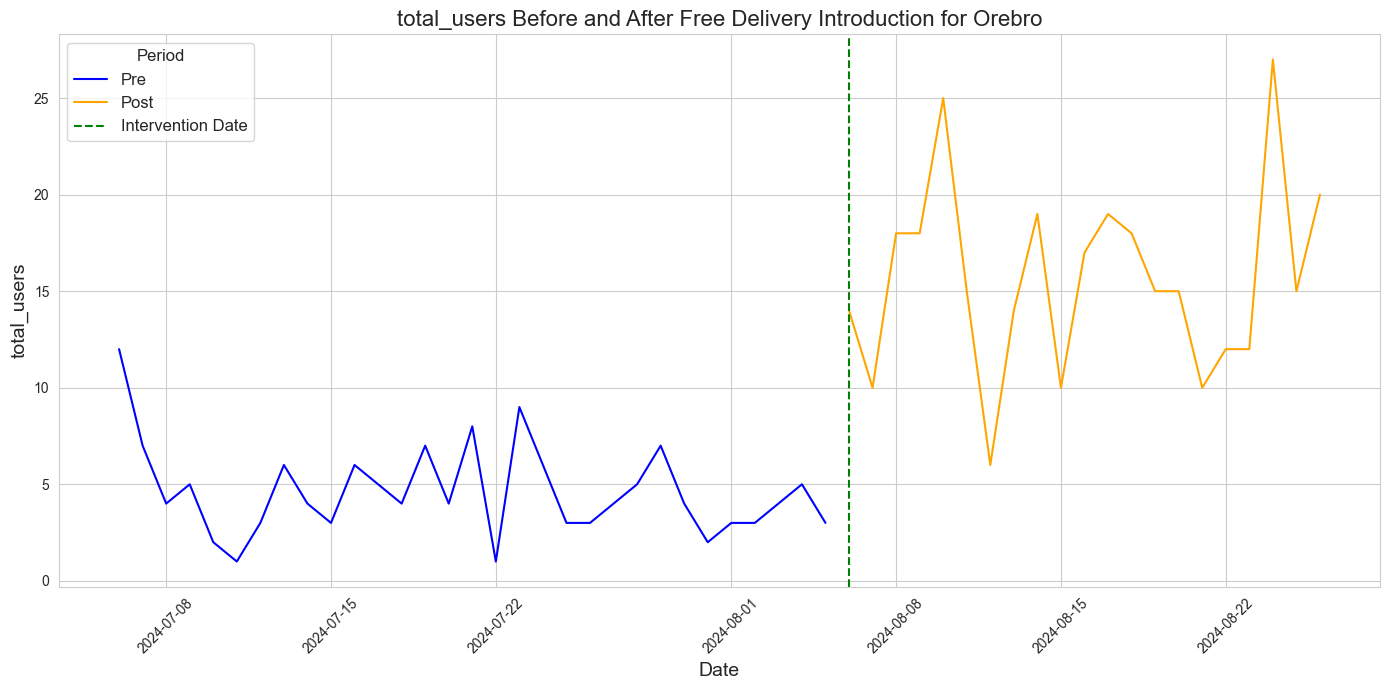

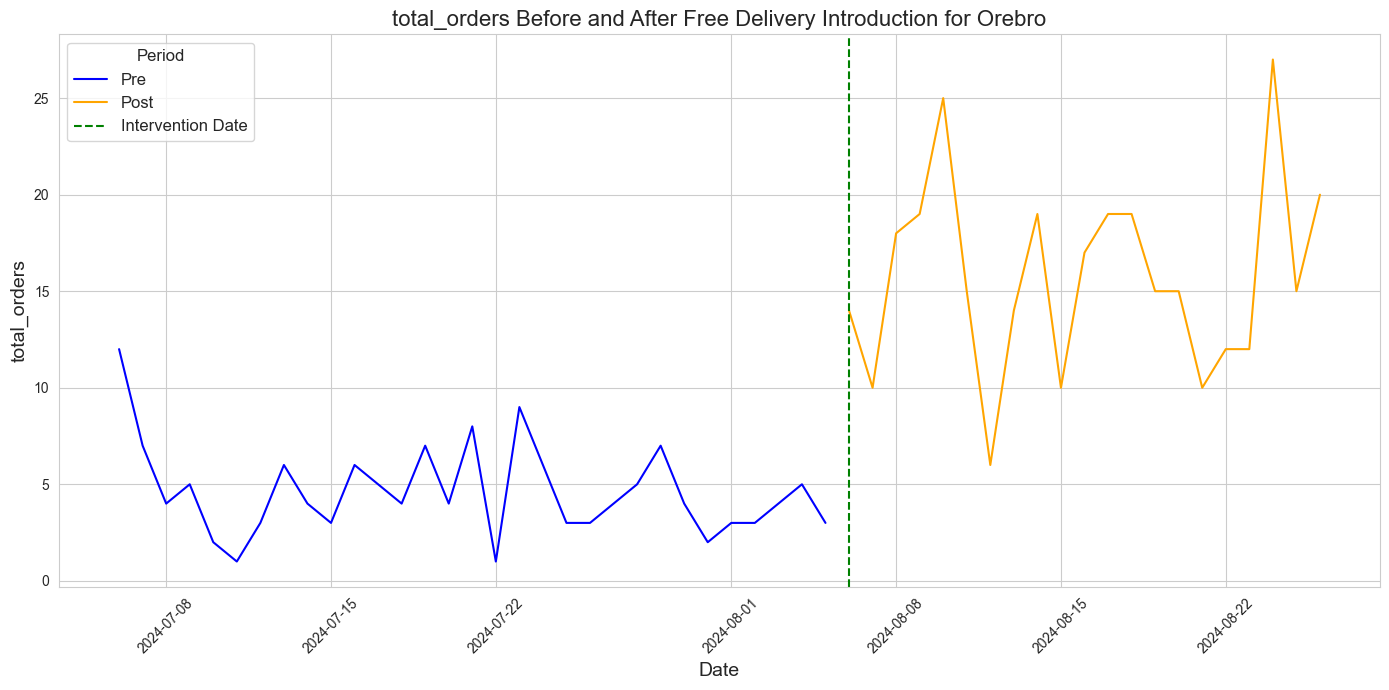

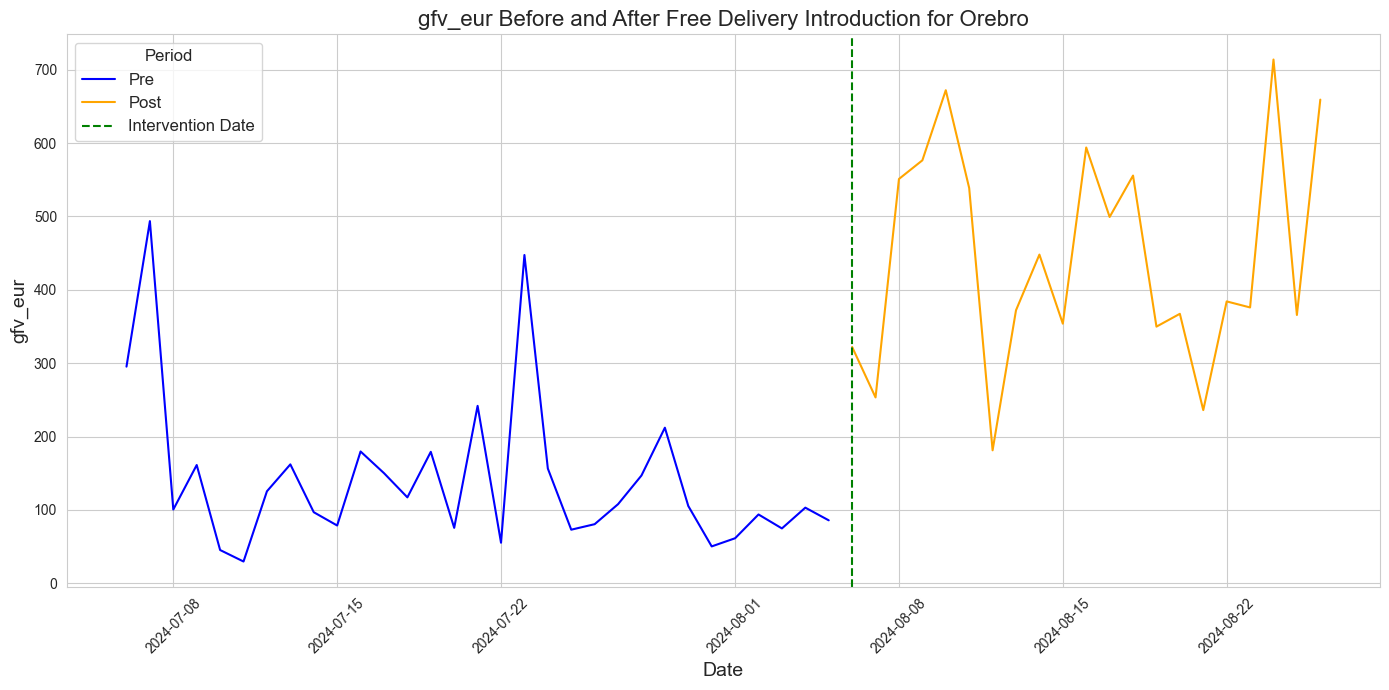

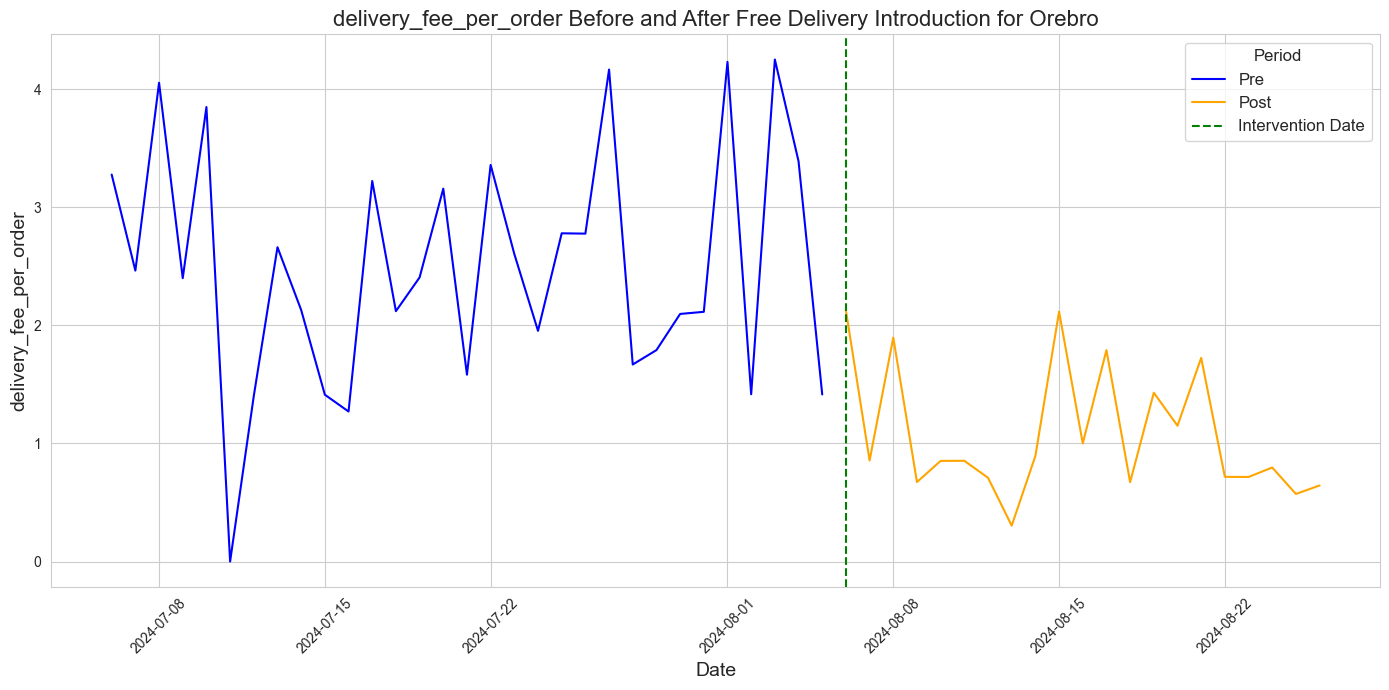

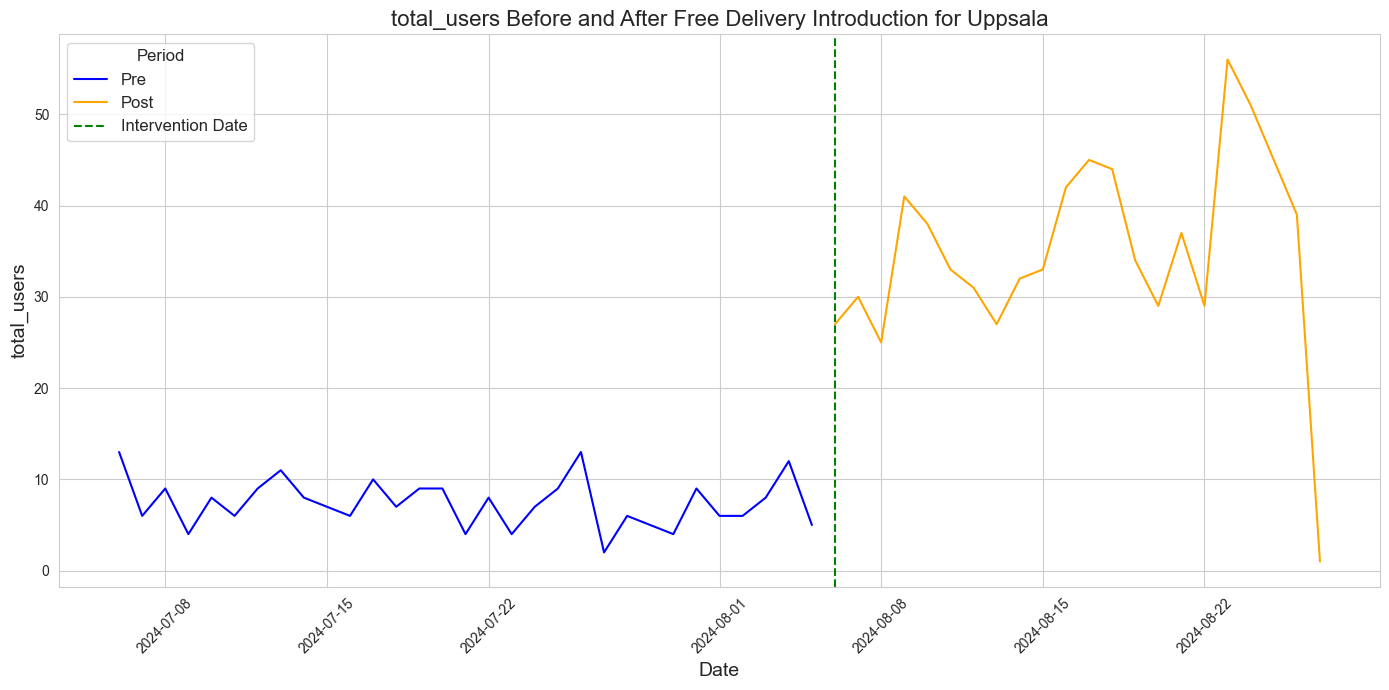

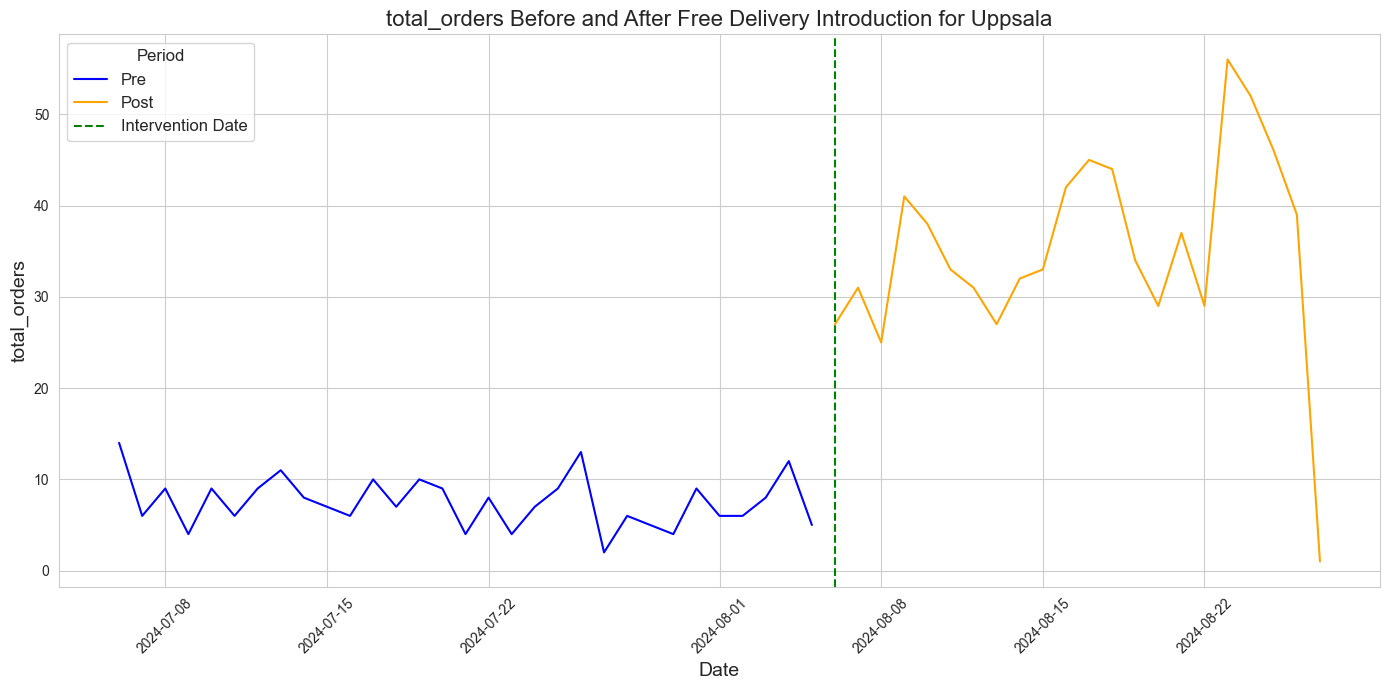

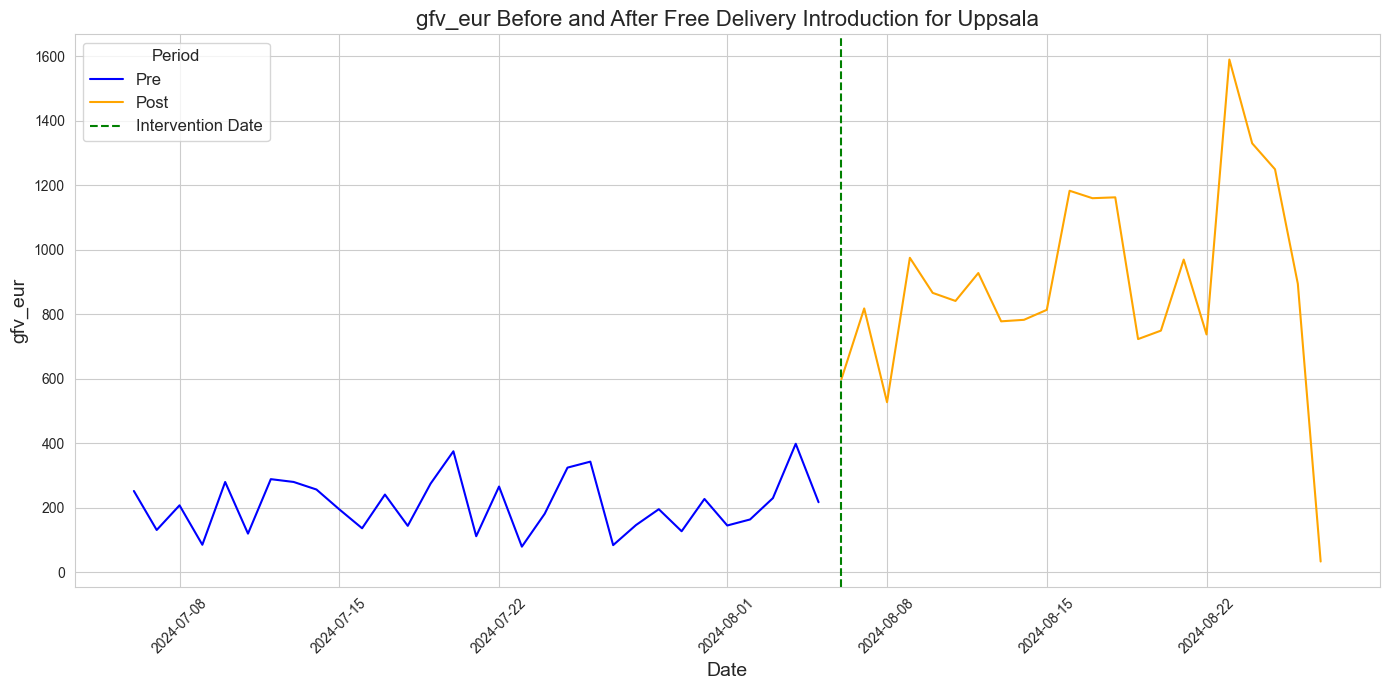

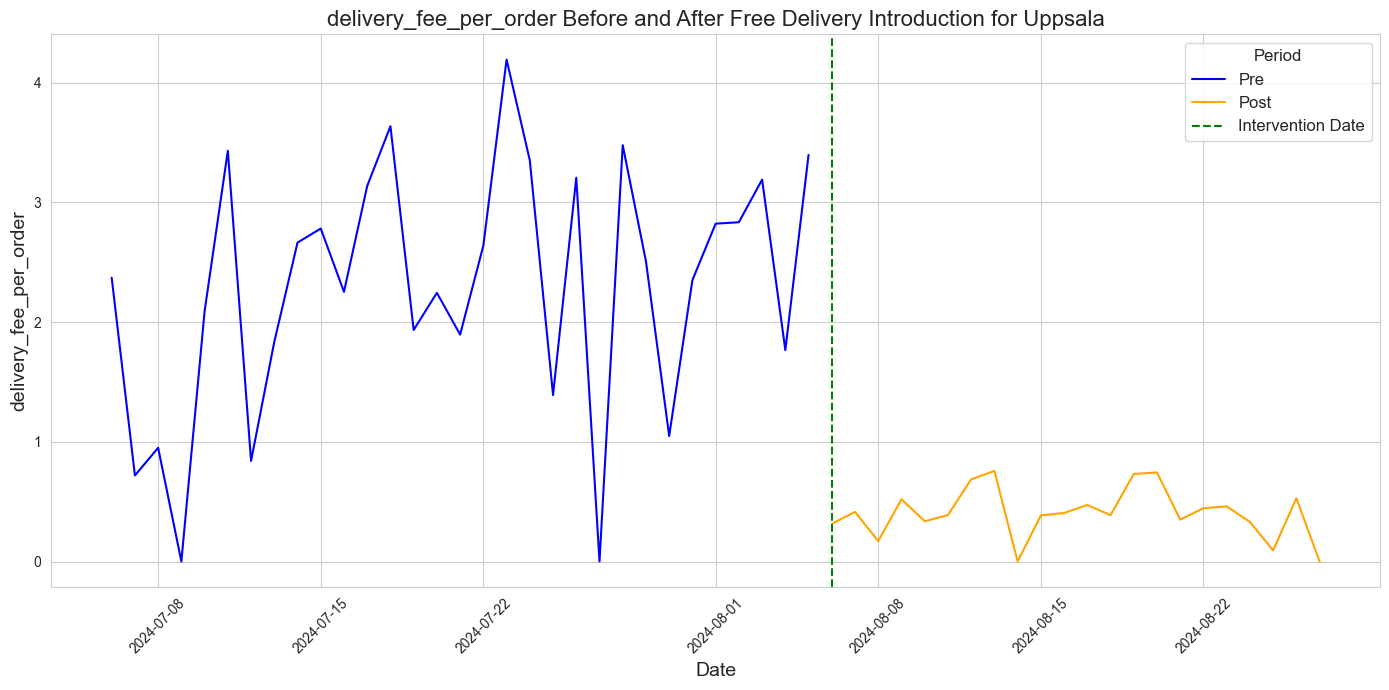

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

metric = ['total_users','total_orders','gfv_eur','delivery_fee_per_order']

for city in filtered_df['city_name'].unique():

    data = filtered_df[(filtered_df['city_name'] == city)]

    for m in metric:

        # Ensure data is sorted by date
        data = data.sort_values('date').reset_index(drop=True)

        # Set plot style
        sns.set_style('whitegrid')

        # Create a figure and axis
        plt.figure(figsize=(14, 7))

        # Plot the line chart
        sns.lineplot(data=data, x='date', y=m, hue='period', palette=['blue', 'orange'])

        # Add vertical line at intervention point
        plt.axvline(x=intervention_date, color='green', linestyle='--', label='Intervention Date')

        # Set titles and labels
        plt.title(m + " Before and After Free Delivery Introduction for " + city, fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel(m, fontsize=14)

        # Customize legend
        plt.legend(title='Period', fontsize=12, title_fontsize=12)

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)

        # Show plot
        plt.tight_layout()
        plt.show()


In [125]:
import statsmodels.api as sm

def its_analysis(data, intervention_date, metric):
    # Convert date to ordinal to use in regression
    data['date_ordinal'] = pd.to_datetime(data['date']).apply(lambda x: x.toordinal())
    
    # Create time variable (days since start)
    data['time'] = data['date_ordinal'] - data['date_ordinal'].min()
    
    # Create intervention dummy
    data['intervention'] = (data['date'] >= intervention_date).astype(int)
    
    # Create interaction term
    data['time_after_intervention'] = data['time'] * data['intervention']
    
    # Ensure that metric column is numeric
    data[metric] = pd.to_numeric(data[metric], errors='coerce')
    
    # Drop rows with any NaN values
    data = data.dropna(subset=['time', 'intervention', 'time_after_intervention', metric])
    
    # Independent variables
    X = data[['time', 'intervention', 'time_after_intervention']]
    X = sm.add_constant(X)  # Add a constant for the intercept
    
    # Dependent variable
    y = data[metric]
    
    # Fit the OLS model
    model = sm.OLS(y, X).fit()
    
    return model


# List to store results
results = {}

# Perform ITS for each city and each metric
for city in filtered_df['city_name'].unique():
    city_data = filtered_df[filtered_df['city_name'] == city].copy()
    city_results = {}
    
    for m in metric:
        model = its_analysis(city_data, intervention_date, m)
        city_results[m] = model.summary()
    
    results[city] = city_results

TypeError: '>=' not supported between instances of 'DateArray' and 'str'

In [126]:
def visualize_its(city_data, intervention_date, metric, model):
    # Convert date to ordinal to use in regression
    city_data['date_ordinal'] = pd.to_datetime(city_data['date']).apply(lambda x: x.toordinal())
    
    # Create time variable (days since start)
    city_data['time'] = city_data['date_ordinal'] - city_data['date_ordinal'].min()
    
    # Create a DataFrame with predictions
    city_data['fitted'] = model.predict(sm.add_constant(city_data[['time', 'intervention', 'time_after_intervention']]))
    
    # Plot the data and the fitted values
    plt.figure(figsize=(14, 7))
    
    # Plot actual data
    sns.lineplot(x='date', y=metric, data=city_data, label='Observed', color='blue')
    
    # Plot fitted values
    sns.lineplot(x='date', y='fitted', data=city_data, label='Fitted', color='red', linestyle='--')
    
    # Add vertical line at intervention point
    plt.axvline(x=intervention_date, color='green', linestyle='--', label='Intervention Date')
    
    # Set titles and labels
    plt.title(f"{metric} Before and After Free Delivery Introduction for {city_data['city_name'].iloc[0]}", fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    
    # Customize legend
    plt.legend(title='Legend', fontsize=12, title_fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Show plot
    plt.tight_layout()
    plt.show()

# Visualize ITS for each city and each metric
for city in filtered_df['city_name'].unique():
    city_data = filtered_df[filtered_df['city_name'] == city].copy()
    
    for m in metric:
        model = its_analysis(city_data, intervention_date, m)
        visualize_its(city_data, intervention_date, m, model)


TypeError: '>=' not supported between instances of 'DateArray' and 'str'

In [127]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

def rdit_analysis(data, intervention_date, metric):
    # Convert date to ordinal
    data['date_ordinal'] = pd.to_datetime(data['date']).apply(lambda x: x.toordinal())
    
    # Create time variable centered around the intervention date
    data['time_centered'] = data['date_ordinal'] - pd.to_datetime(intervention_date).toordinal()
    
    # Create a binary variable for the post-intervention period
    data['post_intervention'] = (data['time_centered'] >= 0).astype(int)
    
    # Create interaction term
    data['time_post_intervention'] = data['time_centered'] * data['post_intervention']
    
    # Ensure the metric column is numeric
    data[metric] = pd.to_numeric(data[metric], errors='coerce')
    
    # Drop rows with missing values in relevant columns
    data = data.dropna(subset=[metric, 'time_centered', 'post_intervention', 'time_post_intervention'])
    
    # Fit the RDiT model using OLS
    formula = f'{metric} ~ time_centered + post_intervention + time_post_intervention'
    model = smf.ols(formula, data=data).fit()
    
    return model

# Perform RDiT analysis for each city and each metric
rdit_results = {}

for city in filtered_df['city_name'].unique():
    city_data = filtered_df[filtered_df['city_name'] == city].copy()
    city_results = {}
    
    for m in metric:
        model = rdit_analysis(city_data, intervention_date, m)
        city_results[m] = model.summary()
    
    rdit_results[city] = city_results


KeyError: 't'

In [128]:
rdit_results

{}

In [129]:
def compare_30_days_pre_post(data, intervention_date, metric):
    # Convert date column to datetime if it's not already
    data['date'] = pd.to_datetime(data['date'])
    
    # Define the date ranges
    pre_period_end = pd.to_datetime(intervention_date) - pd.Timedelta(days=1)
    pre_period_start = pre_period_end - pd.Timedelta(days=29)
    
    post_period_start = pd.to_datetime(intervention_date)
    post_period_end = post_period_start + pd.Timedelta(days=29)
    
    # Filter data for the pre and post periods
    pre_treatment_data = data[(data['date'] >= pre_period_start) & (data['date'] <= pre_period_end)]
    post_treatment_data = data[(data['date'] >= post_period_start) & (data['date'] <= post_period_end)]
    
    # Calculate the average for each period
    pre_treatment_avg = pre_treatment_data[metric].sum()
    post_treatment_avg = post_treatment_data[metric].sum()
    
    # Calculate the difference
    effect = post_treatment_avg - pre_treatment_avg
    
    return pre_treatment_avg, post_treatment_avg, effect

# Example usage for one city and one metric
city = 'Uppsala'
metric = 'total_orders'
intervention_date = '2024-08-06'

city_data = filtered_df[filtered_df['city_name'] == city].copy()

pre_avg, post_avg, effect = compare_30_days_pre_post(city_data, intervention_date, metric)

print(f"Pre-Treatment Average ({metric}): {pre_avg}")
print(f"Post-Treatment Average ({metric}): {post_avg}")
print(f"Effect (Post - Pre): {effect}")

Pre-Treatment Average (total_orders): 219
Post-Treatment Average (total_orders): 772
Effect (Post - Pre): 553


In [130]:
def visualize_rdit(city_data, intervention_date, metric, model):
    # Convert date to ordinal
    city_data['date_ordinal'] = pd.to_datetime(city_data['date']).apply(lambda x: x.toordinal())
    
    # Plot the observed data
    plt.figure(figsize=(14, 7))
    sns.lineplot(x='date', y=metric, data=city_data, label='Observed', color='blue')
    
    # Generate predictions for visualization
    city_data['fitted'] = model.predict(city_data)
    
    # Plot fitted values
    sns.lineplot(x='date', y='fitted', data=city_data, label='Fitted', color='red', linestyle='--')
    
    # Add vertical line at intervention point
    plt.axvline(x=intervention_date, color='green', linestyle='--', label='Intervention Date')
    
    # Set titles and labels
    plt.title(f"RDiT Analysis of {metric} for {city_data['city_name'].iloc[0]}", fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    
    # Customize legend
    plt.legend(title='Legend', fontsize=12, title_fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Show plot
    plt.tight_layout()
    plt.show()

# Visualize RDiT for each city and each metric
for city in filtered_df['city_name'].unique():
    city_data = filtered_df[filtered_df['city_name'] == city].copy()
    
    for m in metric:
        model = rdit_analysis(city_data, intervention_date, m)
        visualize_rdit(city_data, intervention_date, m, model)


KeyError: 't'

In [103]:
import pandas as pd
from prophet import Prophet

# Assuming `a` is already filtered as described
cc = a[['date', 'total_orders']]

# Convert the 'date' column to datetime format
cc['date'] = pd.to_datetime(cc['date'])

# Rename the columns to match what Prophet expects
cc.rename(columns={'date': 'ds', 'total_orders': 'y'}, inplace=True)

# Check the data types to ensure everything is correct
cc.dtypes

# Fit the model
m = Prophet()
m.fit(cc)

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_26580/4055721629.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc['date'] = pd.to_datetime(cc['date'])
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_26580/4055721629.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc.rename(columns={'date': 'ds', 'total_orders': 'y'}, inplace=True)
23:55:27 - cmdstanpy - INFO - Chain [1] start processing
23:55:28 - cmdstanpy - INFO - Chain [1] done processing


/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


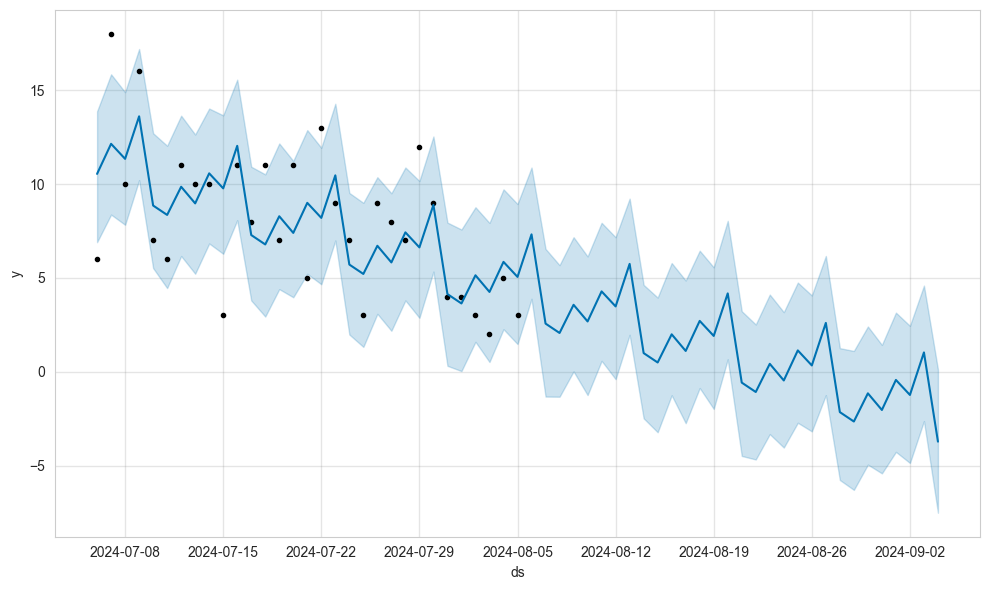

In [104]:
# Python
future = m.make_future_dataframe(periods=30)
future.tail()

# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Python
fig1 = m.plot(forecast)



/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


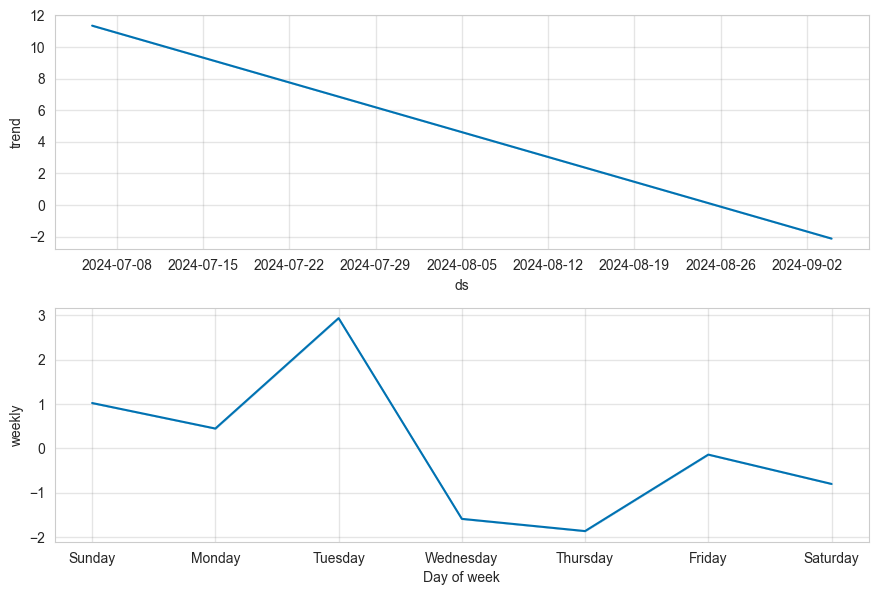

In [105]:
fig2 = m.plot_components(forecast)


In [106]:
# Python
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [107]:
future

,ds
0,2024-07-06
1,2024-07-07
2,2024-07-08
3,2024-07-09
4,2024-07-10
...,...
56,2024-08-31
57,2024-09-01
58,2024-09-02
59,2024-09-03
